In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Function to perform bilinear interpolation.
# Input: All parameters mentioned in https://www.ajdesigner.com/phpinterpolation/bilinear_interpolation_equation.php#ajscroll.
# Output: Interpolated values.
def bilinear_interp(x, y, x1, x2, y1, y2, q11, q12, q21, q22):
    denominator = (x2-x1)*(y2-y1)
    term_0 = ((x2-x)*(y2-y)/denominator)*q11
    term_1 = ((x-x1)*(y2-y)/denominator)*q21
    term_2 = ((x2-x)*(y-y1)/denominator)*q12
    term_3 = ((x-x1)*(y-y1)/denominator)*q22
    return term_0 + term_1 + term_2 + term_3

# Function to apply zero-padding.
# Input: levels (int).
# Output: zero-padded image.
def create_zero_padding(image, levels=1):
    
    for _ in range(levels):    # Membuat padding sejumlah levels.
        zeros_vertical = np.asarray([0]*image.shape[0])[:,np.newaxis]    # Buat array zeros vertikal.
        stacked_horizontally = np.hstack((zeros_vertical, image, zeros_vertical))    # Tempel zeros vertikal di kanan kiri.

        zeros_horizontal = np.asarray([0]*stacked_horizontally.shape[1])[np.newaxis,:]    # Buat array zeros horizontal.
        stacked_vertically = np.vstack((zeros_horizontal, stacked_horizontally, zeros_horizontal))    # Tempel zeros horizontal di atas bawah.
        image = stacked_vertically
        
    return image

# Function to remove zero-padding.
# Input: levels (margin width to remove, int).
# Output: original image if the "levels" matches up exactly with the "levels" in create_zero_padding().
def remove_zero_padding(image, levels=1):
    return image[levels:-levels,levels:-levels]

# Thresholding function.
# Input: center (int), neighbor (int).
# Output: either 1 or 0 depending on the center and neighbor value.
def lbp_sign(center, neighbor):
    if neighbor >= center:
        return 1
    elif neighbor < center:
        return 0

# Function to encode neighbor values.
# Input: center (int), neighbors (1D array).
# Output: new center pixel value for LBP.
def convert_to_decimal(center, neighbors):
    summation = 0
    for i in range(len(neighbors)):
        summation += lbp_sign(center, np.flip(neighbors)[i]) * 2**i
        
    return summation

# Function to extract LBP features. This function is tested only for single-scale (conventional LBP).
# Need more research to ensure P and R values are really able to extract multi-scale features.
# Input: image (2D array), P (sampling points, int), R (radius, int), 
# roll_val (adjusts initial sampling point, int), levels (zero-padding size, int)
# progress (displays progress bar, bool).
def lbp(image, P=8, R=1, roll_val=-3, progress=False):
    
    if progress == True:
        from tqdm import tqdm    # Use progress bar if "progress" is set to True.
    elif progress == False:
        def tqdm(x):             # Does nothing if "progress" is set to False.
            return x
    
    image = create_zero_padding(image)          # Apply zero-padding.
    processed_image = image.copy()              # Create the copy of the current image so that the original image won't get affected.
    
    sampling_points_x = np.roll(np.asarray([-np.round(R*np.sin((2*np.pi*i)/P),3) for i in range(P)]), roll_val)     # Sampling points coordinate in x-axis.
    sampling_points_y = np.roll(np.asarray([np.round(R*np.cos((2*np.pi*i)/P),3) for i in range(P)]), roll_val)      # Sampling points coordinate in x-axis.
    
    height = image.shape[0]
    width = image.shape[1]
    
    for i in tqdm(range(R, height-R)):    # For each row.
        for j in range(R, width-R):    # For each column.
            
            center = image[i,j]       # Acts as the threshold value.
            neighbor_values = []      # "neighbor_values" will be used to store all neighboring values prior to conversion to binary and new center value.
            
            for x, y in zip(sampling_points_x, sampling_points_y):     # Accessing every single sampling point.
                
                x1 = int(np.floor(j+x))
                x2 = int(np.ceil(j+x))
                y1 = int(np.floor(i+y))
                y2 = int(np.ceil(i+y))
                
                q11 = image[y1, x1]
                q12 = image[y2, x1]
                q21 = image[y1, x2]
                q22 = image[y2, x2]
                
                if (x1 != x2) or (y1 != y2):
                    neighbor_value = bilinear_interp(j+x, i+y, x1, x2, y1, y2, q11, q12, q21, q22)
                    neighbor_values.append(round(neighbor_value, 1))
                else:
                    neighbor_values.append(image[round(i+y), round(j+x)])
            
            new_center = convert_to_decimal(center, neighbor_values)   # Use "neighbor_values" to create new center value.
            processed_image[i,j] = new_center
    
    processed_image = remove_zero_padding(processed_image)             # Remove zero-padding.
    
    return processed_image

In [3]:
# How to use the function. The result below has been validated by performing manual calculation.
img = np.asarray([[1,2,3], 
                  [4,5,6], 
                  [7,8,9]])
lbp(img)

array([[28, 30,  6],
       [28, 30,  6],
       [16, 16,  0]])

In [4]:
image = cv2.imread('bmwm5.jpg', 0)
image = cv2.resize(image, dsize=(image.shape[1]//8, image.shape[0]//8))

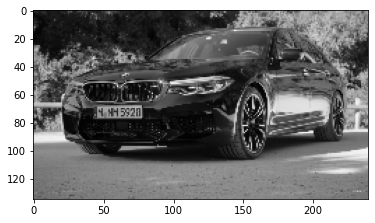

In [5]:
plt.imshow(image, cmap='gray')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:10<00:00, 13.38it/s]


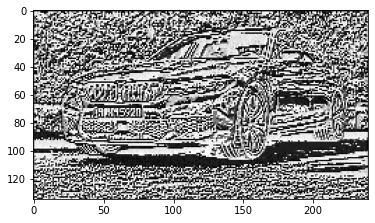

In [6]:
lbp_image = lbp(image, progress=True)
plt.imshow(lbp_image, cmap='gray')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:06<00:00, 20.39it/s]


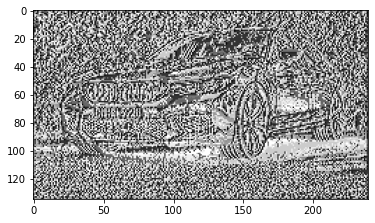

In [7]:
lbp_image = lbp(image, P=4, R=1, progress=True)
plt.imshow(lbp_image, cmap='gray')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 133/133 [00:17<00:00,  7.57it/s]


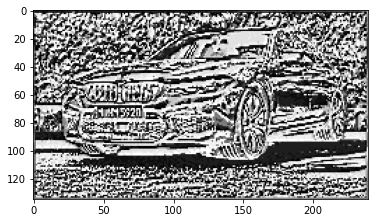

In [8]:
lbp_image = lbp(image, P=8, R=2, progress=True)
plt.imshow(lbp_image, cmap='gray')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 133/133 [00:40<00:00,  3.30it/s]


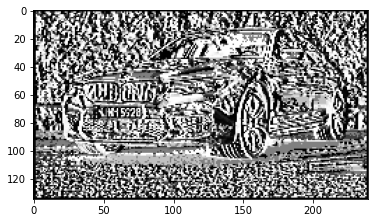

In [9]:
lbp_image = lbp(image, P=16, R=2, progress=True)
plt.imshow(lbp_image, cmap='gray')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:19<00:00,  7.03it/s]


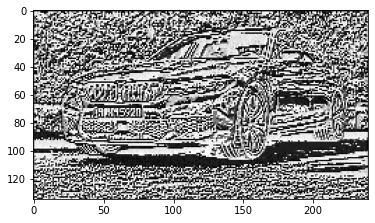

In [10]:
lbp_image = lbp(image, P=8, R=1, progress=True)
plt.imshow(lbp_image, cmap='gray')
plt.show()

In [14]:
np.bincount(lbp_image.flatten())

array([2655,  905,   86,  209,  537,   95,  180,  295,  102,   48,   16,
         30,  196,   44,  480,  729,  911,  379,   42,   65,   90,   27,
         50,   50,  177,   62,   30,   46,  353,   56, 1090, 1090,   96,
         50,    9,   13,   22,    4,   12,    9,   13,    6,    0,    1,
         20,    2,   24,   32,  198,   73,    9,   21,   47,    7,   19,
         11,  165,   34,   19,   26,  240,   25,  288,  249,  518,   83,
         31,   27,  113,   11,   35,   31,   21,    4,    4,    3,   39,
          7,   52,   39,   87,   34,    2,    6,    8,    3,    3,    8,
         32,    5,    4,    1,   32,    6,   23,   38,  208,   67,   10,
         18,   47,    4,   23,   15,   27,    3,    2,    2,   25,    5,
         39,   32,  329,   63,   15,    9,   39,    5,   10,   13,  253,
         25,   30,   25,  275,   15,  280,  200,  102,  194,   15,  141,
         19,   33,   15,  227,    4,   19,    0,   15,    8,   11,   16,
        299,   49,   52,    8,   28,    4,   12,   